<a href="https://colab.research.google.com/github/sunRise9551/GPT_from_Scratch/blob/main/GPT_bigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-10-03 01:37:43--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-10-03 01:37:43 (18.1 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [6]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [7]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [8]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

In [9]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [10]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [11]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

In [12]:
len_data = 10
block_size = 6
batch_size = 4

ix = torch.randint(len_data - block_size, (batch_size, ))

In [13]:
# torch.manual_seed(1337)
torch.manual_seed(133227)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size, ))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

print(get_batch(train_data))

(tensor([[52, 45,  1, 39, 57,  1, 21,  1],
        [51, 43, 56, 56, 63, 11,  1, 63],
        [58, 43, 56, 58, 39, 47, 52, 51],
        [41, 53, 47, 50,  0, 35, 53, 59]]), tensor([[45,  1, 39, 57,  1, 21,  1, 50],
        [43, 56, 56, 63, 11,  1, 63, 53],
        [43, 56, 58, 39, 47, 52, 51, 43],
        [53, 47, 50,  0, 35, 53, 59, 50]]))


In [14]:
print(xb) # our input to the transformer"

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        # --------------------------------------------------------------------------
        """
        cross_entropy requires (B, C, T) or (B, C) where C must always be in the middle.
        """
        B, T, C = logits.shape # retrive the shape of logits
        logits = logits.view(B*T, C) # convert into 2-d
        targets = targets.view(B*T) # converti into 1-d
        # --------------------------------------------------------------------------

        loss = F.cross_entropy(logits, targets)
        return logits, loss

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


We are expecting a log of -ln(1/65) = 4.17438

We are expecting the loss to be around 4.17438

# Generator

We will be creating a Generate function that can generate new token based on given token.


In [27]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):

        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss
    # --------------------------------------------------------------------
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
    # --------------------------------------------------------------------

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

torch.Size([256, 65])
tensor(4.7690, grad_fn=<NllLossBackward0>)


logits, loss = self(idx)
- self(idx) call the forward function
- losgits will be the prediction(scores), loss we ignore here


logits = logits[:, -1, :]

- This line of code is to obtain the marked logits of the current time step generated by the model.
- In text generation tasks, the goal of the model is to generate the next token, which is usually only relevant to the last token in the current context.
- Therefore, to get predictions for the next token, you only need to focus on the logits of the current time step.


So, the purpose of this line of code is to reduce the logits from the shape of (B, T, C) to (B, C) so that it can be further converted to a probability distribution of the next token using the softmax function and sampled to generate the text sequence.

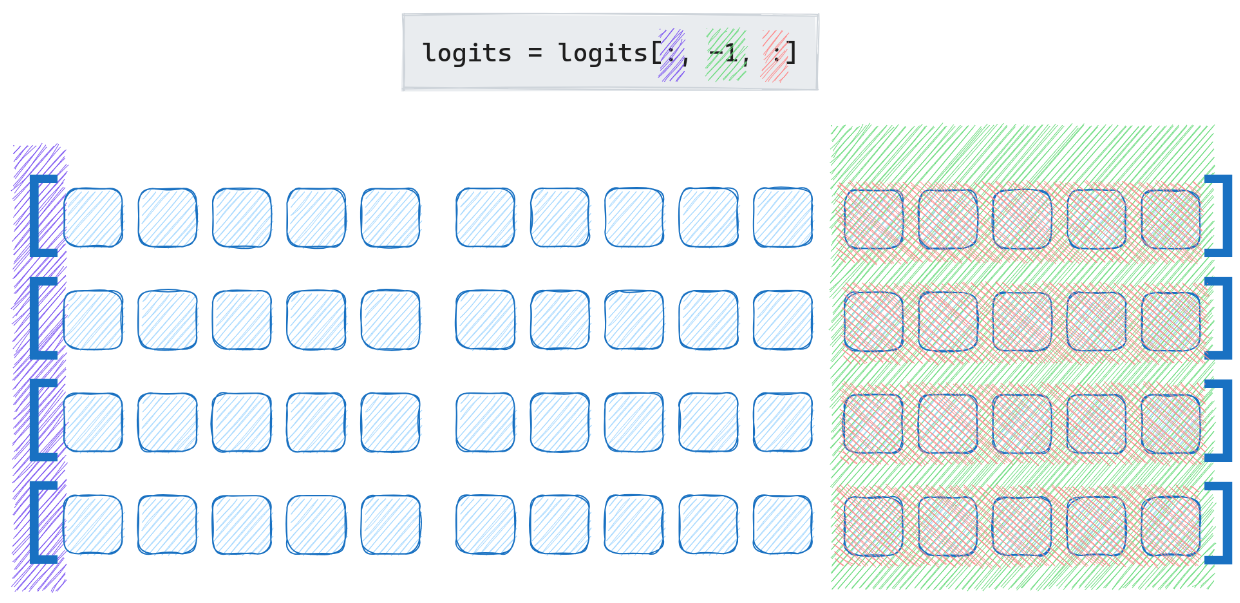

## Edge case - Targets

We are calling forward function on the line ```logits, loss = self(idx)```

But we are not passing any targets into ```def forward(self, idx, targets):```

Therefore we will need to initialize targets with ```def forward(self, idx, targets=None):```
```
if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
```

# Generate Tokens

In [28]:
m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)

idx = torch.zeros((1,1), dtype=torch.long)
max_new_tokens = 100

out = m.generate(idx, max_new_tokens)[0].tolist()
# because we are working with batches:
# [0] is to unpluck the only single dimension that exist in batch
# .tolist() convert to list

decode(out)
# feed in to decode()

"\nhbH\n\n:CLP.A!fq'3ggt!O!T?X!!SA?W&TrpvYybSE3w&S BXUhmiKYyTmWMPhhmnHKj!!btgnwNNULuEzRuYyiWEQxPX!$3C'MBj"

Things to note:

- If we take a closer look, we are actually always feeding in all the generated output, in this case, which is the ```idx```, back into function  ```m.generate```

-  This is because we are just a bigram model, if we would like to predict the next letter after the text ```X``` in this string ```3ggt!O!T?X!!SA?```, the information that the bigram model needs will only be letter ```X```

- This is <font color="red"> not </font> an issue, as right now we are working on just a bigram model, but in future, we will make our model more complex, and consider sequence in the past.

# Train the Model

In [29]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3 )

In [31]:
batch_size = 32
for steps in range(10000):

  # sample a batch of data
  xb, yb = get_batch('train')

  # evaluate loss
  logits, loss = m(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

print(loss.item())

2.531872034072876


In [35]:
out = decode(m.generate(idx = torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist())
print(out)


WA:

SShou mal p the whisa hevel mal ha? mak m s crurathurrathanomof hond, ny, ta Iris;

s nchof ndawa vathan guld whawourgang, the re
iouno we INou a as bly we
BOndeletevewou ay?shy kivassthigu, keak wiratckesthachith Eulia ck tase ak'shu, batran;
ONUCopl
I IINoe he. ule Ofotencho Gonamo cced I: wouclllor wo as ileiler tond 'do ortoutorr dur MERudows ar f, orend,

IS ak,
Thilathe hegr LAnd inguof in.
Aler, ont
QUCERDigunth r, IUSpe, hithomber an tcriset m e wir
t t pere t ave hathe mispr, t erv


# Average Loss

- We will be creating a function that can calculate the average mean of loss over batches.

In [37]:
model = BigramLanguageModel(vocab_size)
eval_iters = 200

def estimate_loss():
  out = {}
  model.eval()
  for split in ['train', 'val']:
    losses = torch.zeros(eval_iters) # create a tensor to store losses over 'eval_iters' numbers of batches
    for k in range(eval_iters):
      X, Y = get_batch(split)
      logits, loss = model(X, Y)
      losses[k] = loss.item() # get the loss, assign it to losses[]
    out[split] = losses.mean() # calculate the loss and assign them accordingly to 'train' or 'val'
  model.train()
  return out

We do not have Dropout or BatchNorm Layer, so setting the model into eval or training mode does not matter now. But its a good practice

# Train Model

In [40]:
max_iters = 3000
eval_interval = 300
learning_rate = 1e-2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
out = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(out)

step 0: train loss 2.4673, val loss 2.4842
step 300: train loss 2.4513, val loss 2.4829
step 600: train loss 2.4581, val loss 2.4921
step 900: train loss 2.4532, val loss 2.4915
step 1200: train loss 2.4579, val loss 2.4949
step 1500: train loss 2.4590, val loss 2.4952
step 1800: train loss 2.4639, val loss 2.4894
step 2100: train loss 2.4539, val loss 2.4888
step 2400: train loss 2.4604, val loss 2.4924
step 2700: train loss 2.4568, val loss 2.4809

BE:
LEESe mevoo s wimicl allit tm gne, ifoofe wecoamindshaine hes, wousth wamy madirgof s;
wiewo 'tin is neave Loushio INCoutengoushou far:

SThesangsefe,
QUSLIO se d o me'
Yofonime mavis an ceame be
Cle omen lar; ist s g tl:
PENGSheeyothay my,-nd T:

Munol tlava daro celisan'd ELLeinglsthenctueshet 'sceheivealave peres t heey ORCENUSTha meme cain ithan fthe thy hee ifous weay l y, cimid f re athoure athal me,
As bend withorvin hin foupeathor bicker f n'e acemyinothe hy her u thanouesst asth tow
